# 05. Profile Likelihoods

Profile likelihoods are a technique to analyse structural and practical identifiability of model parameters. In `estim8`, this procedure samples the likelihood profile of a parameter of interest by fixing it at certain values and then re-estimating the remaining free parameters.

For the interested reader the following references provide an in-depth discussion of the method:
- [A. Raue, C. Kreutz, T. Maiwald, J. Bachmann, M. Schilling, U. Klingmüller, J. Timmer, Structural and practical identifiability analysis of partially observed dynamical models by exploiting the profile likelihood, Bioinformatics, Volume 25, Issue 15, August 2009, Pages 1923–1929, https://doi.org/10.1093/bioinformatics/btp358](https://academic.oup.com/bioinformatics/article/25/15/1923/213246)
- [Kreutz C, Raue A, Kaschek D, Timmer J. Profile likelihood in systems biology. FEBS J. 2013 Jun;280(11):2564-71. doi: 10.1111/febs.12276. Epub 2013 May 9. PMID: 23581573.](https://febs.onlinelibrary.wiley.com/doi/10.1111/febs.12276)

### Imports

In [1]:
import sys 
sys.path.append(r'..')

from estim8.models import FmuModel
from estim8 import visualization, datatypes, Estimator
from estim8.error_models import LinearErrorModel
import pandas as pd

## 6.1 Load the model 

For demonstration purpose, the `SimpleBatch` model introduced in [Notebook 1. Modeling & Simulation](1.%20Modeling%20&%20Simulation.ipynb) is used.

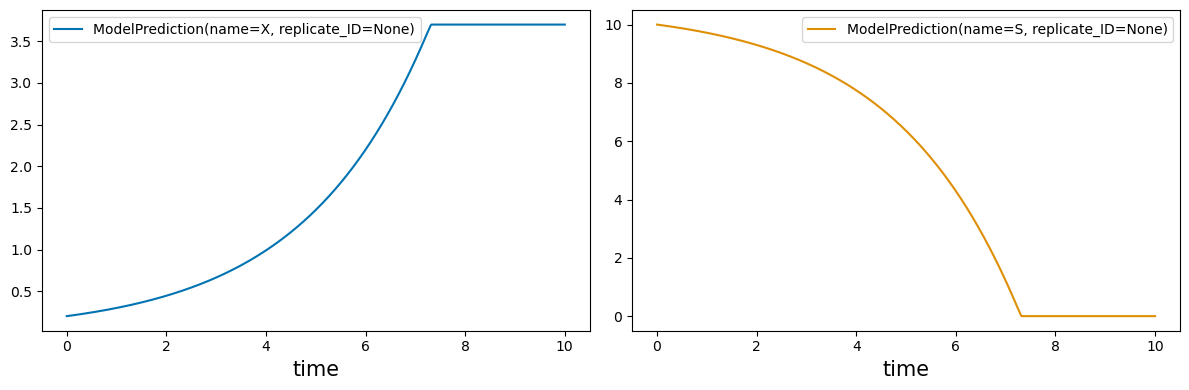

In [2]:
SimpleBatchModel = FmuModel(path='../tests/test_data/SimpleBatch.fmu')

# run a simulation with default parameters
simulation = SimpleBatchModel.simulate(t0=0, t_end=10, stepsize=1e-3, observe=["X", "S"])
_ = visualization.plot_simulation(simulation)

## 6.2 Import experimental data

The profile likelihood method translates the uncertainty in experimental data to model parameters. It is therefore a _likleihood-driven_ techniqe which requires to model the data with some sorft of probability distribution. In this example and in many real world problems, the measurement noise is assumed to be normally distributed, which is the default model in `estim8`'s `LinearErrorModel`:

In [3]:
data = pd.read_excel(r'SimpleBatch_Data.xlsx', index_col=0, header=(0, 1))
data.columns = data.columns.droplevel(1)
data.head()

# assume a linear error model with relative error (scale) of 5% and an absolute error (offset) of 0.01
error_model = LinearErrorModel(
    slope=0.05,
    offset=0.01,
    )
# print the error models error distribution
print(error_model.error_distribution.__class__)

# create an experiment object
experiment = datatypes.Experiment(
    measurements=data,
    error_model=error_model,
    )

<class 'scipy.stats._continuous_distns.norm_gen'>


## 6.3 Defining the estimation problem & create `Estimator` object

Like in [Notebook 3. Parameter estimation](3.%20Parameter%20estimation.ipynb), the estimation problem is defined with unknown model parameters and their bounds. The `Estimator` class then serves as a central hub to collect all inputs and to manage parameter estimations.

In [4]:
## define unknown parameters with upper and lower bounds
bounds = {
    'X0': [0.05, 0.15],
    'mu_max': [0.1, 0.9],
    'Y_XS': [0.1, 1]
}

estimator = Estimator(
    model=SimpleBatchModel,
    bounds=bounds,
    data=experiment,
    t=[0, 10, 0.1],
    metric="negLL"      # use tthe negative log likelihood as the objective function
)

## 6.4 Find the Optimum

The `estimate` method is then used to obtain point estimators.

c:\Users\Tobia\miniforge-pypy3\envs\testim8\lib\site-packages\scipy\optimize\_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


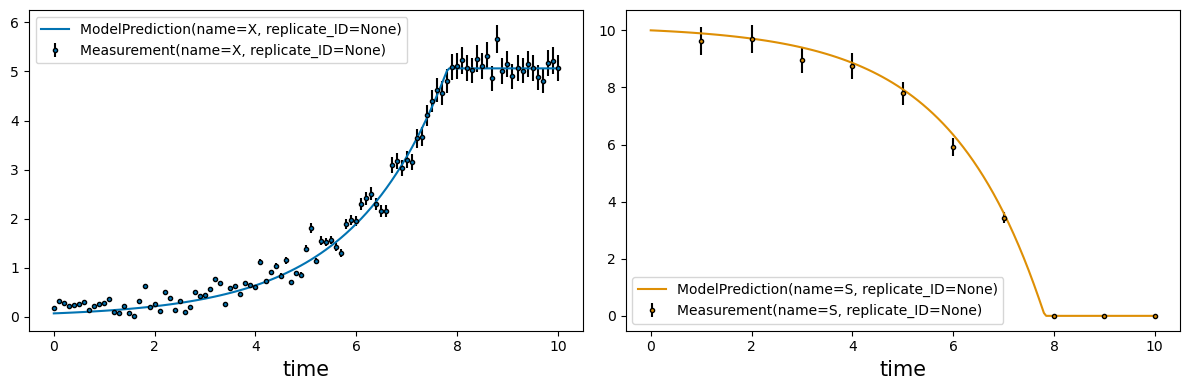

In [129]:
estimates, est_info = estimator.estimate(
    method='de',
    max_iter=1000,
    n_jobs=4,
    optimizer_kwargs={
        "tol": 1e-3
    }
)

_ = visualization.plot_estimates(estimator=estimator, estimates=estimates, only_measured=True)

## 6.5 Profile Likelihood Calculation

The `Estimator`'s `profile_likelihood` function is then used to sample the likelihoods using fixed parameter values in a grid located around the optimum. As this is a technique based on re-estimation, the same arguments for a single parameter estimation task described in [Notebook 3. Parameter estimation](3.%20Parameter%20estimation.ipynb) can be used. The function takes at least the following arguments:

| Arg | Type | Description |
|:----------|:-----|:------------|
| p_opt | dict | The estimated optimal parameters |
| method | str \| List[str] | The optimization method(s) to use |
| max_iter | int | Maximum number of iterations for each optimization |
| n_jobs | int | Parallelization of each individual estimation |

Key-word arguments comprise:

| Kwarg | Type | Description |
|:----------|:-----|:------------|
| optimizer_kwargs | dict | Additional arguments passed to the optimization function |
| p_at_once | int | Number of profile likelihood parameter estimations at once. Default is 1|
| n_points | int | Number of grid points to evaluate per parameter, default is 5 |
| dp_rel | float | Relative parameter variation width (between 0 and 1) for each parameter, default is 0.1 |
| p_inv | list | List of parameters to investigate (defaults to all parameters in p_opt) |

⚠️ This method puts considerable amount of work on your machine!

In [130]:
pl_result = estimator.profile_likelihood(
    p_opt= estimates,    # the optimal parameter set
    method='de',
    optimizer_kwargs={
        "tol": 1e-3
    },        
    max_iter=1000,       # maximum iterations for each estimation run 
    n_jobs=1,            # parallelization of each estimation run 
    p_at_once=6,         # number of estimations to be run in parallel
    stepsize=0.006,      # rleative stepsize for the profile likelihood sampler
)

In [131]:
pl_result

{'X0': array([[6.87554053e-02, 7.51173800e+02],
        [6.91942696e-02, 7.50421800e+02],
        [6.96331339e-02, 7.49755319e+02],
        [7.00719981e-02, 7.49152280e+02],
        [7.05108624e-02, 7.48606577e+02],
        [7.09497267e-02, 7.48097831e+02],
        [7.13885910e-02, 7.47671417e+02],
        [7.18274553e-02, 7.47354938e+02],
        [7.22663196e-02, 7.47061448e+02],
        [7.27051839e-02, 7.46809153e+02],
        [7.31440482e-02, 7.46678900e+02],
        [7.35829125e-02, 7.46592868e+02],
        [7.40217767e-02, 7.46560687e+02],
        [7.44606410e-02, 7.46699006e+02],
        [7.48995053e-02, 7.46713288e+02],
        [7.53383696e-02, 7.46917060e+02],
        [7.57772339e-02, 7.47139563e+02],
        [7.62160982e-02, 7.47442381e+02],
        [7.66549625e-02, 7.47819654e+02],
        [7.70938268e-02, 7.48272526e+02],
        [7.75326911e-02, 7.48243812e+02],
        [7.79715553e-02, 7.48754296e+02],
        [7.84104196e-02, 7.49390010e+02],
        [7.88492839e-02, 7.5

In [132]:
import pickle
with open("pl_res", "wb") as f:
    pickle.dump(pl_result, f)

In [133]:
tmp = pl_result["X0"]

In [134]:
import numpy as np
for key, res in pl_result.items():
    xvals = tmp[:,0]
    y_vals = tmp[:,1]

    if any(np.isnan(y_vals)):
        print(key)
        print(len(xvals)==len(y_vals))

    print(len(xvals)==len(y_vals))

True
True
True


In [135]:
xvals = tmp[:,0]
y_vals = tmp[:,1]

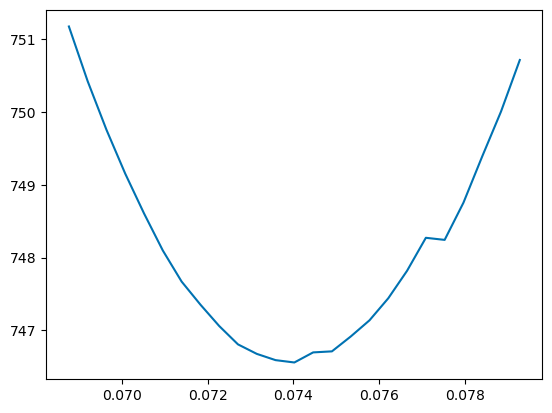

In [136]:
import matplotlib.pyplot as plt
plt.plot(xvals, y_vals)

## 6.6 Evaluation of profile likelihoods




KeyError: "None of ['value'] are in the columns"

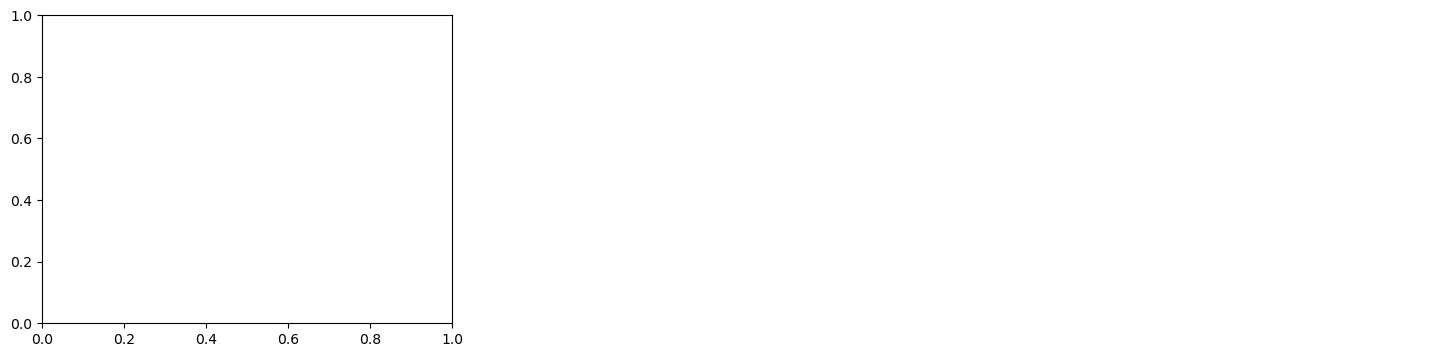

In [137]:
_ = visualization.plot_profile_likelihood(pl_result)

In [138]:
axis_fontsize = 15
rel_figure_width = 6
rel_fig_height = 4
from estim8.profile import calculate_negll_thresshold
import numpy as np

def plot_profile_likelihood(pl_results, p_opt, estimator, alpha=0.05, show_coi=True):
    """
    Plot the profile likelihood results.

    Parameters
    ----------
    pl_results : dict
        The profile likelihood results.

    Returns
    -------
    matplotlib.figure.Figure
        The figure containing the plots.
    """
    

    ncols = min(3, len(pl_results))
    nrows = int(len(pl_results) / ncols) + bool(len(pl_results) % ncols)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(rel_figure_width * ncols, rel_fig_height * nrows),
        sharey=True
    )

    # Calculate threshold and differences
    # define negLL threshhold as stopping criterion
    mle_negll = estimator.objective(list(p_opt.values()))
    threshold = calculate_negll_thresshold(
        alpha=alpha,
        df=len(p_opt),
        mle_negll=mle_negll
    )       


    # ensure axes is array
    axes = np.asarray(axes)

    # turn off empty axes by default
    for ax in axes.flat:
        ax.set_axis_off()

    for ax, (param, results) in zip(axes.flat, pl_results.items()):
        xvals = results[:, 0]
        neglls =  results[:, 1]

        # show point estimate
        ax.axvline(p_opt[param], color='red', linestyle='-', 
                  label=f'MLE: {p_opt[param]:.3f}')

        # show the thresshold for identifiability
        ax.axhline(threshold-mle_negll, linestyle='--', color="grey")

        if show_coi:
            coi = approximate_confidence_interval(xvals, neglls, threshold)

            ax.axvline(coi[0], linestyle='--', color="green")
            ax.axvline(coi[1], linestyle='--', color="green")

           # Add confidence interval to legend
            ax.plot([], [], color="green", linestyle='--', 
                   label=f'{1-alpha} % CoI: {coi[0]:.3f}, {coi[1]:.3f}')
            
            # ax.legend(loc="center", bbox_to_anchor=(0.5, -0.22), ncol=2, fancybox=True)
            ax.legend(loc="best",  ncol=2, fancybox=True)


        ax.set_axis_on()
        

        ax.plot(xvals, neglls-mle_negll , label="Profile Likelihood")
        ax.set_title(param, fontsize=axis_fontsize)
        ax.set_ylabel(r"$\Delta \;  negLL$")
        ax.set_xlabel("value")
       

    fig.tight_layout()
    return fig

In [139]:
len(xvals)

25

In [140]:
from scipy.interpolate import interp1d
def approximate_confidence_interval(xvalues, negll_values, threshold):
    """
    Approximate the confidence interval from the profile likelihood results.

    Parameters
    ----------
    xvalues : np.ndarray
        The x values of the profile likelihood.
    negll_values : np.ndarray
        The negative log likelihood values of the profile likelihood.
    threshold : float
        The threshold of the profile likelihood.

    Returns
    -------
    float
        The lower bound of the confidence interval.
    float
        The upper bound of the confidence interval.
    """

   
    
    # Interpolate to find more precise crossing points
    f = interp1d(xvalues, negll_values-threshold, kind='cubic')
    
    # Create finer grid for interpolation
    x_fine = np.linspace(xvalues.min(), xvalues.max(), 1000)
    y_fine = f(x_fine)
    
    # Find zero crossings
    zero_crossings = np.where(np.diff(np.signbit(y_fine)))[0]
    del f
    
    if len(zero_crossings) >= 2:
        lower = x_fine[zero_crossings[0]]
        upper = x_fine[zero_crossings[-1]]
        return (lower, upper)
    else:
        raise ValueError("Could not find confidence interval bounds - profile may be too flat or not enough points")

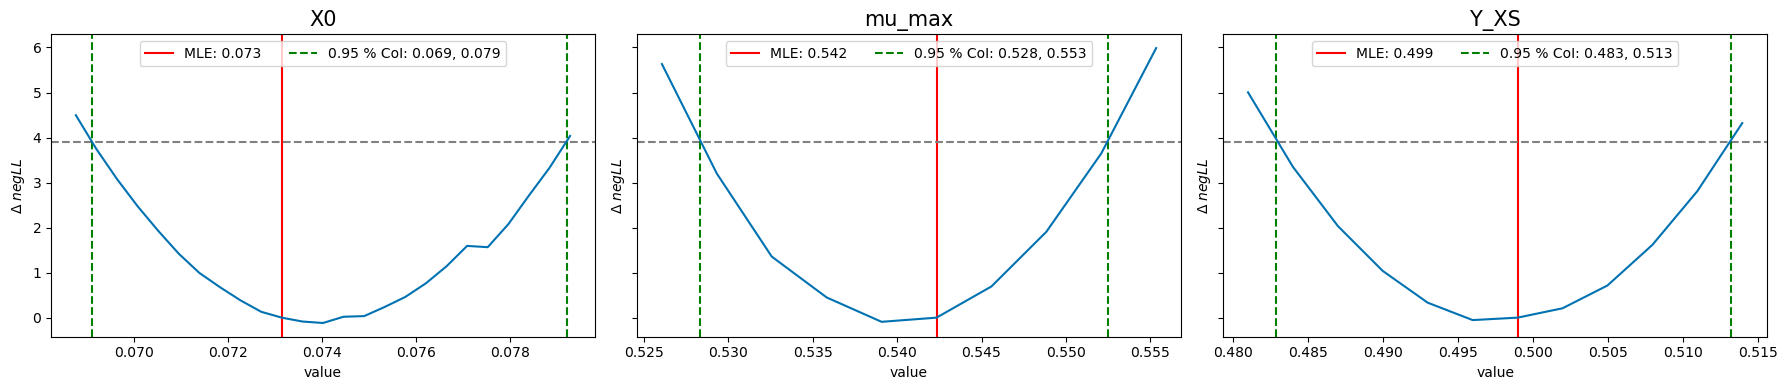

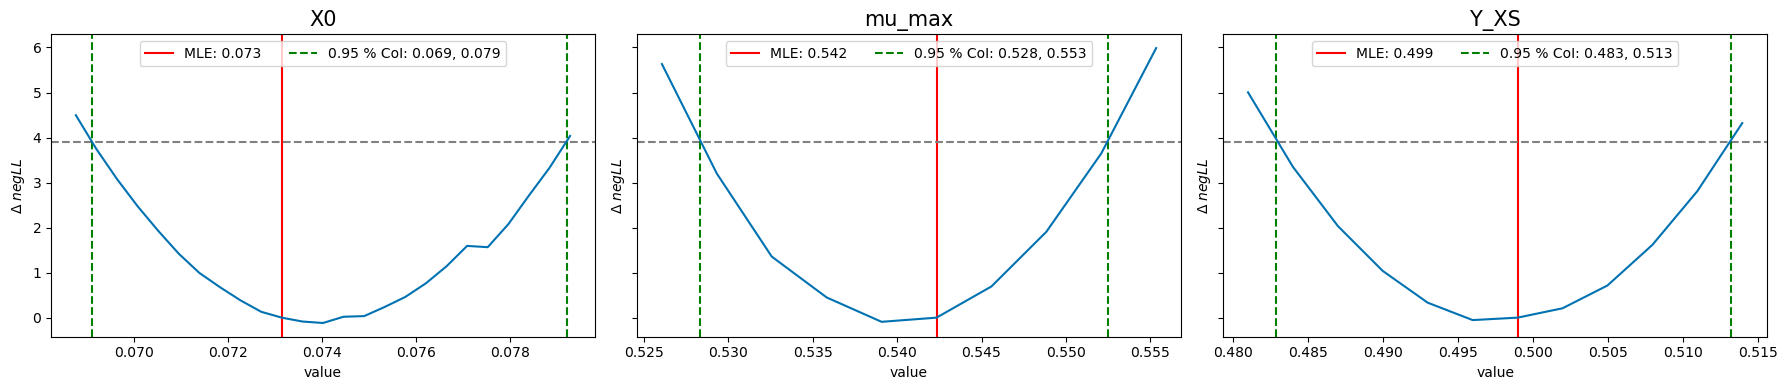

In [141]:
plot_profile_likelihood(pl_result, estimates, estimator, alpha=0.05, show_coi=True)

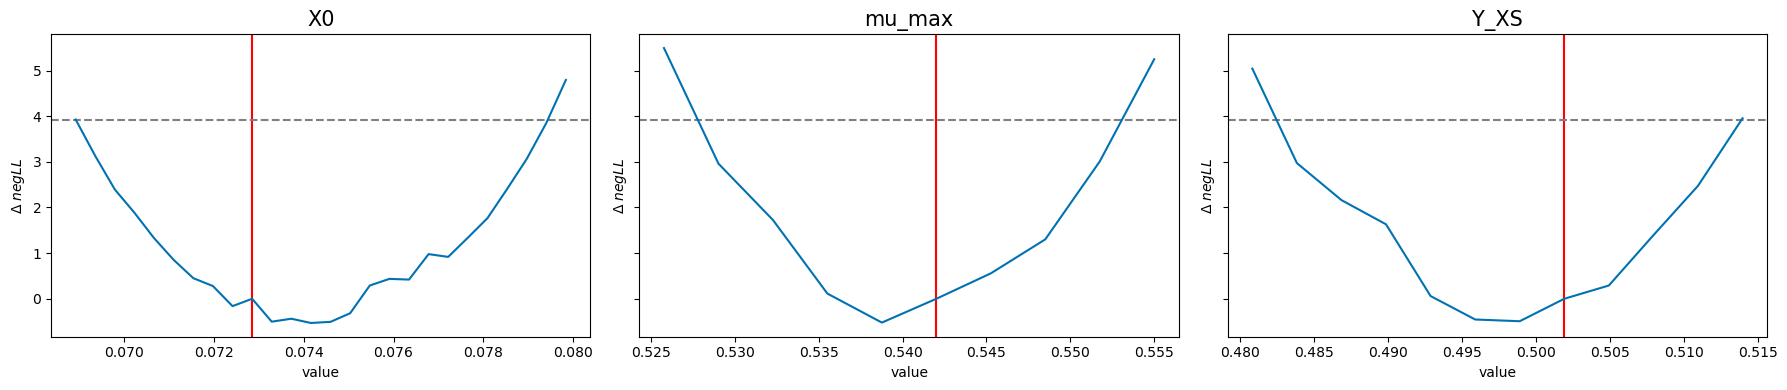

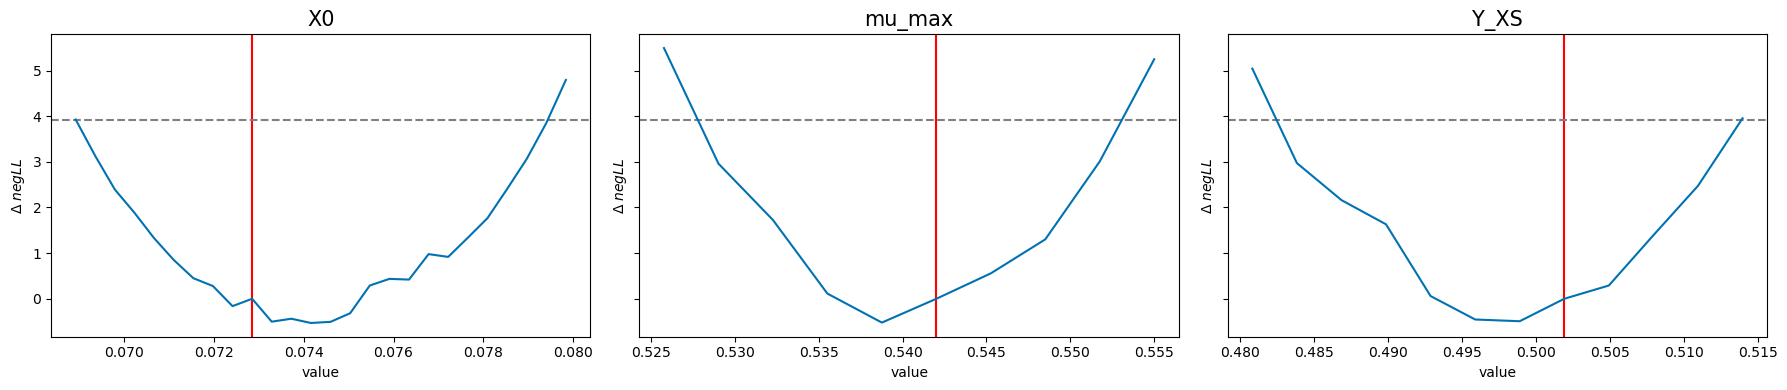

In [128]:
plot_profile_likelihood(pl_result, estimates, estimator, alpha=0.05, show_coi=False)